In [1]:
!which python

/Users/esp.py/Projects/Personal/end-to-end-rag/.venv/bin/python



## Congo News Summarizer. Part one: News Clustering

Over the past months, I have been collecting a lot of news articles from major Congolese news websites. I have those articles saved in a Postgres database. There is a lot of fun stuff I can do with them. Among them is a news summarizer. I want to analyze the daily news and find out what the websites are talking about.

In this blog or series of posts, I will try to build that news summarizer.

In the first part, I will talk about how I built the news clustering model, Then in the second part, I will talk about how I built an LLM that summarizes each news cluster and how I deployed it. Finally, in the last part, I will talk about how to scale the model and deploy it in a production setting.

The end goal of this project is two folds. First, I want  to have a news summarizer that I can open a morning and it will give me a summary of major news that is happening in Congo. Second, while building this news summarizer I would like to sharpen my ML Engineering Knowledge and illustrate that I can build an end-to-end production-ready project with the latest Python stack.

To start, let us talk about how I build the news clustering model.

## 1. Data Collection


### The Data

I have scrappers that run every day and scrape the data that Congolese news websites produce, those articles are saved as text in a Postgres database.  


I  will query that database and load the data in the pandas dataframe for better analysis. I have the code to connect and read from the Postgres database embedded in modules.

In [27]:
%load_ext dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [28]:
%dotenv ./.env_prod -o

cannot find .env file


The above line loads the database credentials so that we can query the database.

In [29]:
from src.shared.database import execute_query, generate_database_connection

In [30]:
experiment_date = "2024-11-06"

In [31]:
yesterday_article_query = f"select content, title, posted_at,url from article where posted_at::date = '{experiment_date}'"

In [32]:
yesterday_article_query

"select content, title, posted_at,url from article where posted_at::date = '2024-11-06'"

In [33]:
from os import getenv

In [34]:
database_user = getenv('POSTGRES_USER')
database_password = getenv('POSTGRES_PASSWORD')
database_host = getenv('POSTGRES_HOST')
database_port = getenv('POSTGRES_PORT')
database_name = getenv('POSTGRES_DB')

In [35]:
database_credentials = {
    'user': database_user,
    'password': database_password,
    'host': database_host,
    'port': database_port,
    'database': database_name
}

In [ ]:
connection = generate_database_connection(database_credential=database_credentials)

TypeError: generate_database_connection() got an unexpected keyword argument 'database_crendentials'

With the credentials, the database connection, the query we can go ahead and query the database to retrieve the data.

In [ ]:
results =execute_query(query=yesterday_article_query, database_connection=connection)

In [ ]:
results[0].title

'Ligue 2 : après la préparation, New Soger de retour à Lubumbashi et ambitionne la première division du championnat national, recrutement et staff technique au grand complet avant le démarrage | Actualite.cd'

We have our results in a list now we can put them in a dataframe from further analysis.

In [ ]:
import pandas as pd

In [ ]:
news_df  = pd.DataFrame.from_records(results)

In [ ]:
news_df.head()

,0,1,2,3
0,"La ligue nationale de football, dans sa deuxiè...","Ligue 2 : après la préparation, New Soger de r...",2024-11-06 07:41:00,https://actualite.cd/2024/11/06/ligue-2-apres-...
1,"Au cours d'un point de presse lundi dernier, l...","Affaire Mike Mukebayi: “Croyez-moi, nous somme...",2024-11-06 08:05:00,https://actualite.cd/index.php/2024/11/06/affa...
2,"Parmi les avancées majeures de ce projet, la S...",Kinshasa : la SNEL SA modernise son Réseau éle...,2024-11-06 00:00:00,https://econewsrdc.com/kinshasa-la-snel-sa-mod...
3,"novembre 6, 2024 Linafoot 2024/25 : L’OC Renai...",Linafoot 2024/25 : L’OC Renaissance frappée pa...,2024-11-06 00:00:00,https://depeche.cd/2024/11/06/linafoot-2024-25...
4,"novembre 6, 2024 Présidentielle Américaine: Fé...",Présidentielle Américaine: Félix Tshisekedi fé...,2024-11-06 00:00:00,https://depeche.cd/2024/11/06/presidentielle-a...


In [ ]:
news_df.columns =  ["content", "title", "posted_at", "url"]

In [ ]:
from pathlib import Path

In [ ]:
current_directory = Path.cwd().parent.parent

In [ ]:
current_directory

PosixPath('/Users/esp.py/Projects/Personal/end-to-end-rag')

In [ ]:
news_directory = current_directory.joinpath("datasets", "today_news")

In [ ]:
news_directory.mkdir(exist_ok=True)

In [ ]:
from datetime import datetime

In [ ]:
today = datetime.now().strftime("%Y-%m-%d")

In [ ]:
news_df.to_csv(news_directory.joinpath(f"{today}-news.csv"))

In [ ]:
news_df.head()

,content,title,posted_at,url
0,"La ligue nationale de football, dans sa deuxiè...","Ligue 2 : après la préparation, New Soger de r...",2024-11-06 07:41:00,https://actualite.cd/2024/11/06/ligue-2-apres-...
1,"Au cours d'un point de presse lundi dernier, l...","Affaire Mike Mukebayi: “Croyez-moi, nous somme...",2024-11-06 08:05:00,https://actualite.cd/index.php/2024/11/06/affa...
2,"Parmi les avancées majeures de ce projet, la S...",Kinshasa : la SNEL SA modernise son Réseau éle...,2024-11-06 00:00:00,https://econewsrdc.com/kinshasa-la-snel-sa-mod...
3,"novembre 6, 2024 Linafoot 2024/25 : L’OC Renai...",Linafoot 2024/25 : L’OC Renaissance frappée pa...,2024-11-06 00:00:00,https://depeche.cd/2024/11/06/linafoot-2024-25...
4,"novembre 6, 2024 Présidentielle Américaine: Fé...",Présidentielle Américaine: Félix Tshisekedi fé...,2024-11-06 00:00:00,https://depeche.cd/2024/11/06/presidentielle-a...


## Reading the data from LocalFile
Alternatively to reading the data from the database you can read it form the CSV file at this [path](../data/2024-11-06-news.csv) and load it in a dataframe named `news_df`.

In [1]:
import pandas as pd

In [2]:
from pathlib import Path
current_directory = Path.cwd()

In [3]:
data_path = current_directory.joinpath("data", "2024-11-06-news.csv")

In [8]:
news_df = pd.read_csv(data_path, index_col=0)

### Preprocessing.


In the above code, we have collected the data for the previous day. For one given day, we can have up to 72 news articles written by different news outlets.

We have got our news dataset, we need to now do some preprocessing. The only preprocessing we will do will be to drop the duplicate in the content.

In [10]:
news_df = news_df.drop_duplicates(subset="content").reset_index(drop=True)

In [11]:
news_df.head()

,content,title,posted_at,url
0,"Au cours d'un point de presse lundi dernier, l...","Affaire Mike Mukebayi: “Croyez-moi, nous somme...",2024-11-06 08:05:00,https://actualite.cd/index.php/2024/11/06/affa...
1,"Parmi les avancées majeures de ce projet, la S...",Kinshasa : la SNEL SA modernise son Réseau éle...,2024-11-06 00:00:00,https://econewsrdc.com/kinshasa-la-snel-sa-mod...
2,Désavouée par 17 députés nationaux de 3 Allian...,Désavouée par les députés nationaux de 3 Allia...,2024-11-06 08:08:15,https://scooprdc.net/2024/11/06/desavouee-par-...
3,"novembre 6, 2024 Linafoot 2024/25 : L’OC Renai...",Linafoot 2024/25 : L’OC Renaissance frappée pa...,2024-11-06 00:00:00,https://depeche.cd/2024/11/06/linafoot-2024-25...
4,"novembre 6, 2024 Présidentielle Américaine: Fé...",Présidentielle Américaine: Félix Tshisekedi fé...,2024-11-06 00:00:00,https://depeche.cd/2024/11/06/presidentielle-a...


## 2. Embedding phase.

Machine learning models don't work with text data, we need to convert the text into a representation that computers can understand. To achieve this we need to use embeddings. We will use an  embedding  model to learn the representation of our dataset in an embedding space.

We will be using the `dunzhang/stella_en_400M_v5`, it is a good model from Huggingface, It offers a good trade-off between size and performance.  It has a good score on different tasks in both French and English on the [MTEB leaderboard.](https://huggingface.co/spaces/mteb/leaderboard)

The below code section assumes that we have the model downloaded in a local repository of our machine. If you want to download the model locally you can refer to this [script](put the path here) to learn how to download the model locally.

The code will load the embedding model and use it to encode the news. After the encoding, we will have for each news article an embedding vector of shape 1024.

In [12]:
embedding_model_id = "dunzhang/stella_en_400M_v5"

In [13]:
current_directory

PosixPath('/Users/esp.py/Projects/Personal/congo-news-summarizer')

In [14]:
model_path  = current_directory.joinpath(embedding_model_id)

In [15]:
embedding_model_path = current_directory.joinpath("models", embedding_model_id)

In [16]:

transformer_kwargs = {"model_name_or_path": embedding_model_path.__str__(),
                      "trust_remote_code": True,
                      "device": "cpu",
                      "config_kwargs": {"use_memory_efficient_attention": False,
                                        "unpad_inputs": False},
                      "cache_folder": model_path}

In [17]:
from sentence_transformers import SentenceTransformer

/Users/esp.py/Projects/Personal/congo-news-summarizer/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [18]:
sentence_transformer_model = SentenceTransformer(
    **transformer_kwargs)

Some weights of the model checkpoint at /Users/esp.py/Projects/Personal/congo-news-summarizer/models/dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
today_news_embeddings = sentence_transformer_model.encode(
    news_df.content.tolist())

/Users/esp.py/Projects/Personal/congo-news-summarizer/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:1161: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [20]:
today_news_embeddings.shape

(79, 1024)

Now we have encoded our news for each news we have an embedding vector of shape 1024. With those embeddings, we can now start clustering.

## 3. Clustering Experiments

### Kmeans


In this step, we will group our news embeddings in a cluster using the K-mean algorithm. The algorithm will try to group the news in clusters based on the similarity of their embedding vectors. After the clustering, we will have similar news grouped in similar clusters. You can learn more about the clustering algorithm [here](https://www.reddit.com/r/learnmachinelearning/comments/rmx04g/what_is_K-means_clustering_a_2minute_visual_guide/)

#### How do we pick the number of clusters?

One question that is still unclear in the literature about K-mean is how to pick the number of clusters in the K-mean. 
A common approach is to use the Silhouette Coefficient. In the next section, I will explain that coefficient. 

#### Silhouette Score.



>The Silhouette Coefficient is a measure of how well samples are clustered with samples that are similar to themselves. Clustering models with a high Silhouette Coefficient are said to be dense, where samples in the same cluster are similar to each other, and well separated, where samples in different clusters are not very similar to each other.



Given a point $x_i$ that belongs to a cluster labeled $c_i$. To compute the silhouette score:
- We compute the mean distance of the $x_i$ to all the other points in cluster $c_i$, we call it $a_i$.

  ${\displaystyle a_i={\frac {1}{|C_{I}|-1}}\sum _{j\in C_{I},i\neq j}d(i,j)}$

  Note that we divide $C_i - 1$ which is the number of points in the cluster minus the current point.
  
- Then we compute $b_i$, which  measure how the point $x_i$ in cluster $c_i$ is dissimilar to all other clusters $c_j$ with $c_j != c_i$.

For each other clusters different $c_i$ we compute the mean distance between $x_i$ and all the points in the cluster.  Then we take the cluster that has the mean distance as the closest cluster to $x_i$.

We define $b_i$ as:

${\displaystyle b_i=\min _{J\neq I}{\frac {1}{|C_{J}|}}\sum _{j\in C_{J}}d(i,j)}$


With those $a_i$, and $b_I$ we define the silhouette score of the point $x_i$ as $s_i$ to be

${\displaystyle s_i={\frac {b_i-a_i}{\max\{a_i,b_i\}}}}$

This value varies between -1 and 1. 1 means our clusters are dense, and -1 means the opposite.

Let us write a Python function that will perform the clustering and return the k that gives us the best cluster.



In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [22]:

def find_best_estimator (X):
    """ compute the k mean clustering, and return the best k that maximizes the silhouette score
    """
    k_mean_estimators = [
        (f"KMeans_{i}", KMeans(n_clusters=i, random_state=42, max_iter=3000)) for i in range(3, X.shape[0])]
    scores = []

    best_estimator = None
    best_metric = float("-inf")
    for estimator_name, estimator in k_mean_estimators :
        estimator.fit(X)
        labels = estimator. labels_
        score = silhouette_score(
            X, labels)
        if score > best_metric :
            best_metric = score
            best_estimator = estimator
        scores.append(score)
    return best_estimator, scores

In the above function, we perform a clustering by selecting the number of clusters to be between 3 and the total number of documents, which is less than 100 in our case.

The we compute the silhouette score, after computing the scores we return the estimator that gives us the best value of that score.

In [23]:
best_estimator, scores = find_best_estimator(today_news_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Let plot now the similarity shilouette score and see how it grow with the number of cluster selected.

In [24]:
import matplotlib.pyplot as plt

In [25]:
axes = plt.figure(figsize=(5, 10))

<Figure size 500x1000 with 0 Axes>

In [26]:
axes = plt.figure(figsize=(5, 10))

<Figure size 500x1000 with 0 Axes>

Text(0.5, 1.0, 'silhouette score vs Number of Cluster')

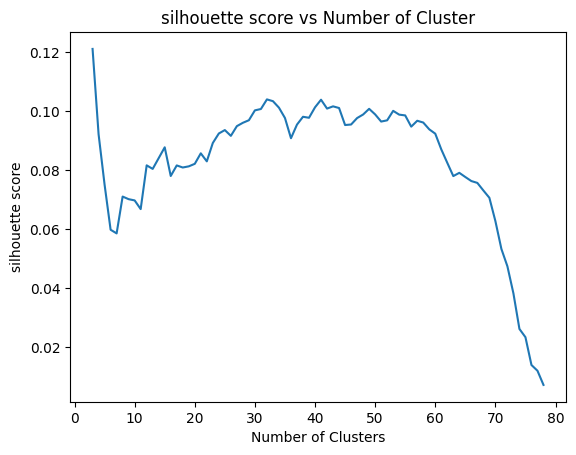

In [27]:
fig, ax = plt.subplots()
ax.plot(range(3, today_news_embeddings.shape[0]), scores)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("silhouette score")
ax.set_title("silhouette score vs Number of Cluster")

In [28]:
best_estimator

KMeans(max_iter=3000, n_clusters=3, random_state=42)

We can see that the best estimator gave us the n cluster equal to 50

In [29]:
news_df["k_means_labels"] = best_estimator.labels_

Now let us analyze the clustering results.

In [30]:
def analyse_embeddings(dataframe, embeddings, index, label_column="labels"):
    """ take a matrix of embeddings and the labels.
    for each label compute the cosine similarity of the document with that label.
    """
    document_in_index = dataframe.query(f"{label_column} == {index}")
    with pd.option_context('display.max_colwidth', None):
        display(document_in_index.title)
    document_index = document_in_index.index
    vectors = embeddings[document_index]
    return sentence_transformer_model.similarity(vectors,  vectors)

In [31]:
analyse_embeddings(news_df, today_news_embeddings,29, label_column="k_means_labels")

Series([], Name: title, dtype: object)

tensor([], size=(0, 0))

In [32]:
news_df.shape

(79, 5)

After the first look at the results we can see that the results are good, we have around 50 news clusters, for 79 news.
Some news clusters have only one article which makes sense, and others have up to 6 articles. In the later analysis, we will only keep news articles that have more than one document.

Can we do better than that? Let's now try hierarchical clustering.


## Hierarchical Clustering

Hierarchical clustering is a clustering that uses an iterative approach to build the `dendrogram`.

A dendrogram is a representation of a tree. Hierarchical clustering illustrates the arrangement of the clusters produced by the corresponding analyses.

**How do we build a dendrogram?**

Assuming we have `n` points that we would like to cluster, the algorithm starts with them and a similarity metric to use.
In the first step, all the `n` points are grouped in a `n ` cluster, as each observation is treated as a separate cluster.
Then, the next two similar clusters are fused into a cluster; at this point, we have `n-1` clusters.
The algorithm will process iteratively  by fusing similar clusters into each other until we have one cluster.  
With one cluster we have our dendrogram complete.

In the figure, [Put the figure here], illustrate a dendrogram resulting from the clustering.


**How do we compute the similarity between clusters?**

We have the notion of similarity between two points but how do we compute the similarity between a point and a cluster or between two clusters?
The notion of similarity between two points can be extended to develop the notion of `linkage` which is how we evaluate the similarity between two groups of observation or clusters.
Given two clusters A and B, linkage metrics start by computing the pairwise  dissimilarity between the observations in cluster A and those in cluster B. 

Depending on how we compute the overall dissimilarity from those pairwise dissimilarities, the linkage metric will be defined.

The linkage is called:

- __complete__: When overall dissimilarity is the largest of the pairwise dissimilarity.

- __single__:  When overall dissimilarity is the smallest of the pairwise dissimilarity.  

- __average__: When overall dissimilarity is the average of the pairwise dissimilarity.


With the understanding of Hierarchical clustering and the linkage metric, let's implement hierarchical clustering using the `scipy package`.

### Hierarchical Clustering with Scipy.


To implement the hierarchical clustering, we will use two functions from the `scipy` package, the `linkage` and the `dendrogram` function.

The linkage function performs the clustering, it takes the input embeddings a numpy array, the linkage method, and the similarity metric and it returns the hierarchical clustering tree encoded as a linkage matrix. 

We use the `dendrogram` function to generate the tree plot of the linkage matrix.
The bellow code illustrates how the clustering is performed.



In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage

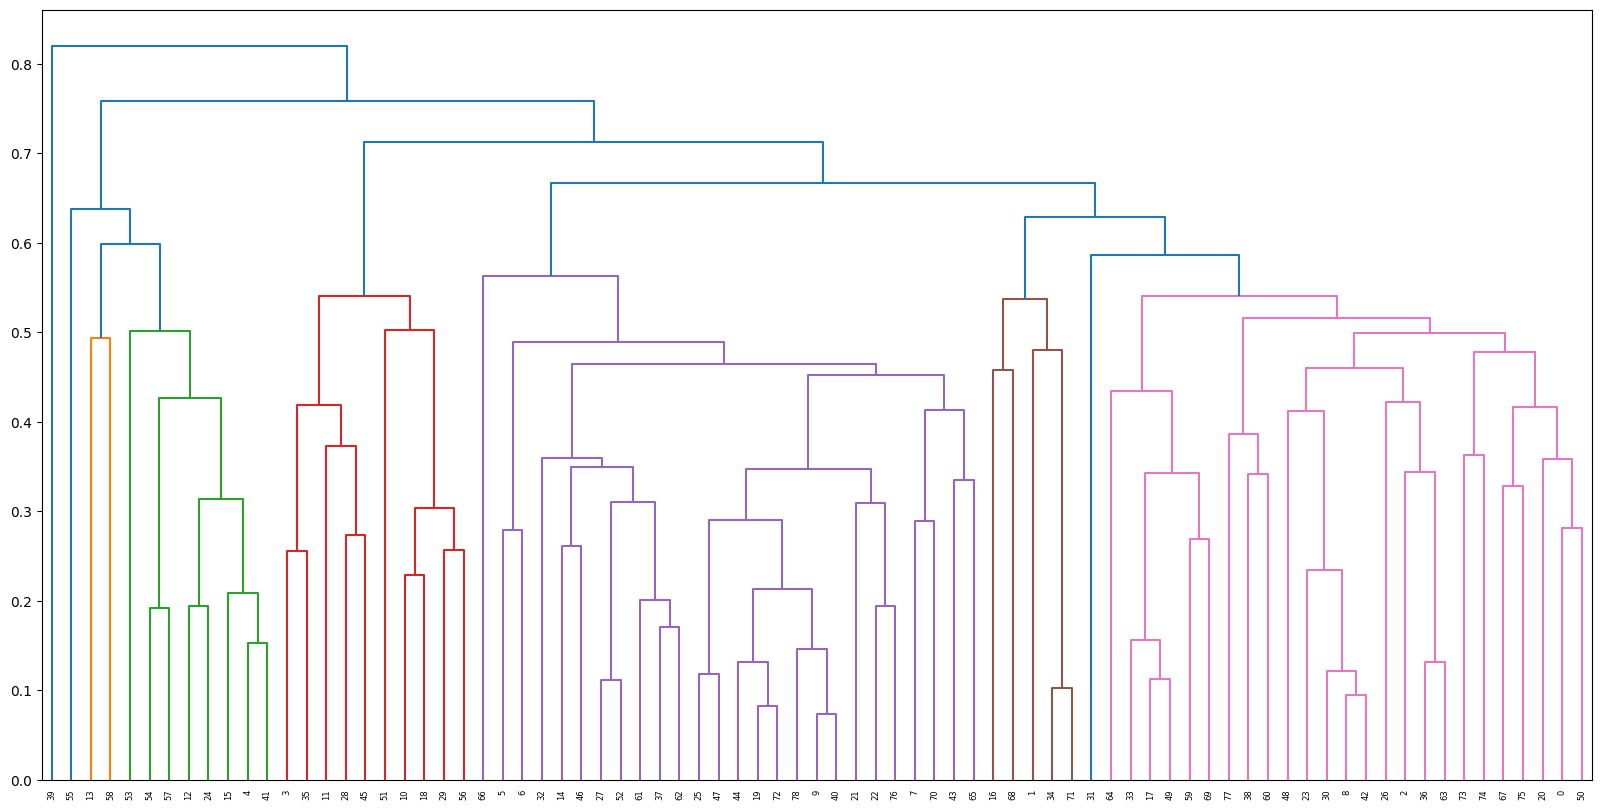

In [34]:
# Complete Linkage
plt.figure(figsize = (20,10))
mergings = linkage(today_news_embeddings,
                   method='complete', metric='cosine')
dendrogram(mergings)
plt.show()

As the result of the hierarchical clustering is a tree, which can be visualized as a dendrogram.

In the above plot, the x-axis represents the documents that are grouped into clusters based on the color, and the y-axis represents the distance cut-off used while computing the merging. The distance on the `y` axis is 1-cosine similarity.


The _y_ axis represents the distance cut-off used while computing the merging.
The _x_ axis represents the documents that are grouped into clusters based on the color.

__A quick note on the `merging` value__: 
    
The result of the linkage function is a matrix, we will call it `merging matrix`.

Each row of the merging matrix is in the format `[cluster_index, cluster_index, distance, sample_count]`, the column index is the ith iteration at which that merging was done.

Recall that we said that hierarchical clustering considers each point as a separate cluster to start with and then iteratively merges those points two by two to create new clusters. 

Let's have a look at what happened in the first 8 iterations of our algorithm.


In [35]:
import numpy as np

In [36]:

merging_with_cosine_distance = mergings.copy()
merging_with_cosine_distance[:, 2] = 1 - merging_with_cosine_distance[:, 2] # the distance is 1 - the cosine similarity
with np.printoptions(precision=3, suppress=True):
    print(merging_with_cosine_distance[:9])

[[ 9.    40.     0.927  2.   ]
 [19.    72.     0.918  2.   ]
 [ 8.    42.     0.906  2.   ]
 [34.    71.     0.898  2.   ]
 [27.    52.     0.889  2.   ]
 [17.    49.     0.887  2.   ]
 [25.    47.     0.882  2.   ]
 [30.    81.     0.878  3.   ]
 [44.    80.     0.869  3.   ]]



In the above matrix, we can see the first element contains `[9, 46, 0.92, 2]`. It tells us that after the first iteration  the document with id 9 and 46 were grouped together and their cosine similarity is 0.92.

Let see how what is inside those two documents: 


In [37]:

with pd.option_context('display.max_colwidth', None):
        display(news_df.iloc[[9, 46]].title)




9     RD -États généraux de la justice : “Un minimum de volonté de nous tous suffit pour que nous ayons un appareil judiciaire fort” (Félix Tshisekedi)
46                                   Liberté de la presse : « Il y a une loi aujourd’hui qui garantit la protection des journalistes » (Patrick Miyaya)
Name: title, dtype: object




We can check other documents in the merging to understand how the merging works. When we get to the 9th iteration we can see that it merged 3 samples and the second cluster index  at that iteration is not a single document, its index is 80 which is greater than the number of documents we have in our set(79). That means that cluster 50 has only one document: document 50 was merged with cluster 80 which contains 2 documents. They were merged at a distance of 0.878.

The cluster 80 is built with documents merged in the `80 - len(document)th` iteration. In our case, it represents the documents merged in the 1st iteration(80 - 79). From the above matrix, we can see that in the first iteration documents 9 and 40 were merged. With that, we can say that at the 9th iteration, the three documents that were merged are documents with ID: 9, 46, and 50. Let's see what those documents look like from our set.


In [38]:
with pd.option_context('display.max_colwidth', None):
        display(news_df.iloc[[9, 46, 50]].title)

9     RD -États généraux de la justice : “Un minimum de volonté de nous tous suffit pour que nous ayons un appareil judiciaire fort” (Félix Tshisekedi)
46                                   Liberté de la presse : « Il y a une loi aujourd’hui qui garantit la protection des journalistes » (Patrick Miyaya)
50                                                                      Goma: le gouvernement provincial remet un lot de vivres à la prison de Munzenze
Name: title, dtype: object

By looking at the merging matrix we can understand how our clustering algorithm works! One of the main advantages of hierachical clustering is its explainability, in most business cases stakeholders will prefer to work with an explainable model than a non-explainable model or  black box model.

In [39]:
import numpy as np
from scipy.cluster.hierarchy import fcluster


### Selecting the cluster labels for the documents.

The `fcluster` function helps take a distance cut-off and return the cluster label of each document with the value of k as the distance cut-off. So if we say k = 0.2, the function will give us the clustering of the document assuming that the max distance of the document in a cluster is 0.2.

But how do we find the best k to select? 

- We can use domain knowledge. 
- We can fine-tune that metric. We have decided to fine-tune, and by fine-tuning we select the k that gives us the best silhouette score. 

The below code performs fine-tuning and returns the k that maximizes the silhouette score.

In [40]:
def select_best_distance(X, merging):
    """ start with the document embedding x, and the hierarchical clustering, find the k that maximize the shilouette score"""
    max_shilouette = float("-inf")
    return_labels = np.zeros(X.shape[0])
    scores = []
    number_of_clusters = []
    best_k = 0
    all_k = []
    for k in np.arange(0.1, 0.5, 0.01):
        labels = fcluster(merging, k, criterion="distance")
        n_clusters = np.unique(labels).shape[0]
        if n_clusters <=2 or n_clusters >=(X.shape[0]-1):
            continue
            # doesn't meet the condition
        score = silhouette_score(
            X, labels
        )
        scores.append(score)
        all_k.append(k)
        number_of_clusters.append(n_clusters)
        if score > max_shilouette:
            max_shilouette = score
            return_labels = labels
            best_k = k
    return scores, return_labels, number_of_clusters, all_k, best_k

In [41]:
scores, label_hierarchical, number_of_clusters, all_k, best_k =  select_best_distance(today_news_embeddings, mergings)

In [42]:
best_k

0.4199999999999998

Text(0.5, 1.0, 'silhouette score vs distance metric')

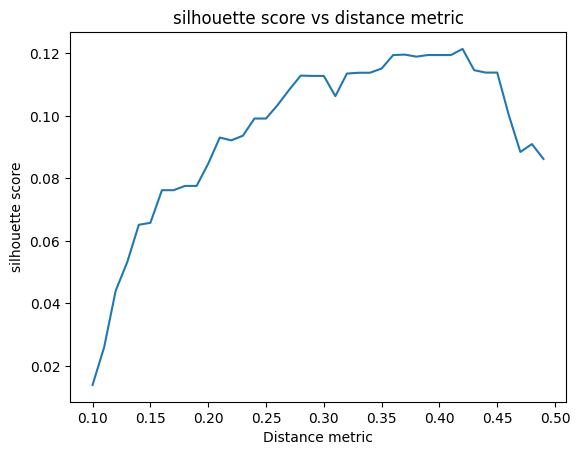

In [43]:
fig, ax = plt.subplots()
ax.plot(all_k, scores)
ax.set_xlabel("Distance metric")
ax.set_ylabel("silhouette score")
ax.set_title("silhouette score vs distance metric")

The above plot illustrates how the silhouette score varies by the distance metric we select.
Either at 0.4 stabilize at that point before a jump at around 0.4 to 0.65.

In [44]:
np.unique(label_hierarchical).shape

(28,)

In [45]:
max(scores)

0.12144723

In [46]:
best_k

0.4199999999999998

Text(0.5, 1.0, 'distance vs number of clusters')

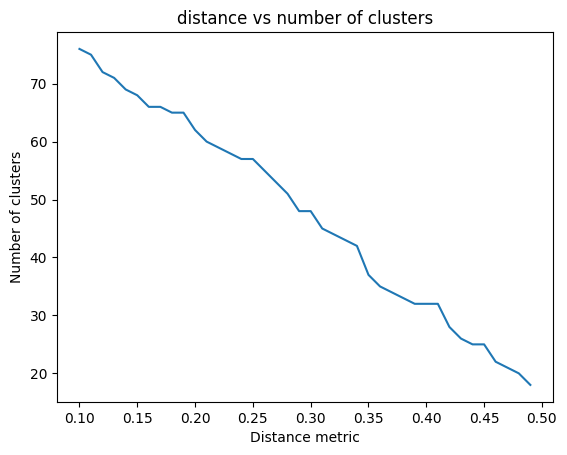

In [47]:
fig, ax = plt.subplots()
ax.plot(all_k, number_of_clusters)
ax.set_xlabel("Distance metric")
ax.set_ylabel("Number of clusters")
ax.set_title("distance vs number of clusters")

In [48]:
news_df.head()

,content,title,posted_at,url,k_means_labels
0,"Au cours d'un point de presse lundi dernier, l...","Affaire Mike Mukebayi: “Croyez-moi, nous somme...",2024-11-06 08:05:00,https://actualite.cd/index.php/2024/11/06/affa...,1
1,"Parmi les avancées majeures de ce projet, la S...",Kinshasa : la SNEL SA modernise son Réseau éle...,2024-11-06 00:00:00,https://econewsrdc.com/kinshasa-la-snel-sa-mod...,1
2,Désavouée par 17 députés nationaux de 3 Allian...,Désavouée par les députés nationaux de 3 Allia...,2024-11-06 08:08:15,https://scooprdc.net/2024/11/06/desavouee-par-...,1
3,"novembre 6, 2024 Linafoot 2024/25 : L’OC Renai...",Linafoot 2024/25 : L’OC Renaissance frappée pa...,2024-11-06 00:00:00,https://depeche.cd/2024/11/06/linafoot-2024-25...,0
4,"novembre 6, 2024 Présidentielle Américaine: Fé...",Présidentielle Américaine: Félix Tshisekedi fé...,2024-11-06 00:00:00,https://depeche.cd/2024/11/06/presidentielle-a...,2


In [49]:
news_df["label_hierachical"] = label_hierarchical

In [50]:
news_df["label_hierachical"].value_counts()

label_hierachical
12    11
11     8
26     5
19     5
7      5
4      5
22     5
13     4
8      4
23     3
21     3
3      2
17     2
25     2
10     2
18     1
27     1
15     1
1      1
28     1
9      1
5      1
6      1
2      1
20     1
14     1
16     1
24     1
Name: count, dtype: int64

In [51]:
news_df.query("label_hierachical == 11")

,content,title,posted_at,url,k_means_labels,label_hierachical
14,Intervenant ce mardi 05 novembre 2024 lors de ...,"Droits de l’homme en RDC: à l'ONU, le Conseil ...",2024-11-06 11:08:00,https://actualite.cd/2024/11/06/droits-de-lhom...,1,11
27,"À l’issue de cette audience, Adama Dieng a fél...",L’UA promet d’accompagner la RDC dans la prote...,2024-11-06 05:34:07,https://actu30.cd/2024/11/lua-promet-daccompag...,1,11
32,"À l’en croire, en dépit de la situation sécuri...",RDC : « La pratique de LGBT ne fait pas partie...,2024-11-06 00:51:31,https://actu30.cd/2024/11/rdc-la-pratique-de-l...,1,11
37,C’est une escale verbale entre le ministre con...,Au conseil des droits de l’homme de l’ONU : Mu...,2024-11-06 00:00:00,https://www.mediacongo.net/article-actualite-1...,1,11
46,"Dans son intervention, ce mardi, lors de l’exa...",Liberté de la presse : « Il y a une loi aujour...,2024-11-06 00:00:00,https://www.mediacongo.net/article-actualite-1...,1,11
52,"Ce mardi 5 novembre 2024, le président de la R...",RDC-UA : le Président Félix Tshisekedi et Adam...,2024-11-06 00:00:00,https://www.mediacongo.net/article-actualite-1...,1,11
61,L’état de guerre (bien que non déclarée) entre...,Luanda : une bataille sémantique,2024-11-06 00:00:00,https://econewsrdc.com/luanda-une-bataille-sem...,1,11
62,La complexité des relations entre Kinshasa et ...,Les relations en dents de scie entre Kinshasa ...,2024-11-06 00:00:00,https://econewsrdc.com/les-relations-en-dents-...,1,11


In [52]:
analyse_embeddings(news_df, today_news_embeddings, 4, "label_hierachical")

4                                                                 Présidentielle Américaine: Félix Tshisekedi félicite Donald Trump pour sa victoire 
12                 États-Unis-RDC : tensions, sanctions et partenariats sous Trump et Biden, vers une politique africaine incertaine ? | Actualite.cd
15                                          Félix Tshisekedi félicite Donald Trump et appelle à un renforcement du partenariat RDC-USA | Actualite.cd
24                                                                   Présidentielle américaine : les félicitations de Félix Tshisekedi à Donald Trump
41    Le Président Félix Tshisekedi Félicite Donald Trump pour sa victoire à la présidentielle américaine et souhaite renforcer les relations RDC-USA
Name: title, dtype: object

tensor([[1.0000, 0.8071, 0.8000, 0.8352, 0.8468],
        [0.8071, 1.0000, 0.7536, 0.8064, 0.7537],
        [0.8000, 0.7536, 1.0000, 0.6866, 0.7909],
        [0.8352, 0.8064, 0.6866, 1.0000, 0.7866],
        [0.8468, 0.7537, 0.7909, 0.7866, 1.0000]])

Once i have got the best labeling, i can go ahead and select the most important cluster. 

This will be all the cluster with more than 1 document, the rest of the document will be considered as noise. 

In [53]:
cluster_counts = news_df.label_hierachical.value_counts()
labels_with_more_than_one = cluster_counts[cluster_counts > 1].index

In [54]:
important_news_df = news_df.loc[news_df.label_hierachical.isin(labels_with_more_than_one)]

In [55]:
np.unique(important_news_df.label_hierachical).shape[0]

15

### Conclusions


In this notebook, we went through the process of building a new clustering system. We started by pulling the data from the database, then we computed the news embedding using the embedding model. With the embedding vectors of the news, we started the clustering. We explained the silhouette score, which is the metric we use to evaluate the quality of clusters resulting from a clustering algorithm, and then we explained and performed hierarchical clustering on our news embeddings. At the end of the hierarchical clustering, we ended up with news clusters finally we saved those data in a file for further analysis and downstream applications.

In the next post, we will move from the jupyter notebook to a production-ready application. We will learn how to productionarize this simple news clustering system. Stay tuned for that post.

At this point we have a notebook with the clustering results and those results are saved back in the folder. The next step will be to build a new cluster component that will be used in a downstream application.


Reference:

- [Article on The clustering](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)
- Introduction to Statistical learning page 520-534.
- Wikipedia on the clustering.
